## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Лебеденко  |
|---------|------------|
| Группа  | М8о-301Б-19|

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

Теперь загружаем датасет:

In [2]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [3]:
import numpy as np

In [4]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features'].astype(np.float32)/256

Смотрим на то, какие данные получились:

In [5]:
data.shape

(42000, 784)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [6]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels,test_size=0.25)

In [7]:
import matplotlib.pyplot as plt 
from matplotlib import gridspec

In [8]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In [9]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

In [10]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)
                
    def compile(self, loss=None, metrics=["accuracy"]):
        self.loss = loss
        self.metrics = metrics
    
    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss.forward(p,y)
        pred = np.argmax(p,axis=1)
        acc = (pred==y).mean()
        return l, acc
    
    def fit(self, X_train, y_train, batch_size=4, epochs=10, validation_data=None, lr=0.3):
        X_test, y_test = validation_data
        history = []
        train_loss, train_acc = self.get_loss_acc(X_train, y_train)
        test_loss, test_acc = self.get_loss_acc(X_test, y_test)
        history.append([train_acc,train_loss,test_acc,test_loss])
        
        for i in range(4):
            print(f"Initial {['train_acc','train_loss','test_acc','test_loss'][i]}: {history[-1][i]}")

        for epo in range(epochs):
            for i in range(0,len(X_train),batch_size):
                xb = X_train[i:i+batch_size]
                yb = y_train[i:i+batch_size]
                p = self.forward(xb)
                l = self.loss.forward(p,yb)
                dp = self.loss.backward(l)
                dx = self.backward(dp)
                net.update(lr)
            train_loss, train_acc = self.get_loss_acc(X_train, y_train)
            test_loss, test_acc = self.get_loss_acc(X_test, y_test)
            history.append([train_acc,train_loss,test_acc,test_loss])
            print(f"epoch: {epo+1}/{epochs}")
            for i in range(4):
                print(f"{['train_acc','train_loss','test_acc','test_loss'][i]}: {history[-1][i]}")
            #print("confusion matrix:", self.get_conf_mat(X_train, y_train), sep='\n')
        return history

In [11]:
net = Net()
net.add(Linear(784, 10))
net.add(Softmax())
net.compile(loss=CrossEntropyLoss())

hist = net.fit(train_data,train_labels, lr=0.001, epochs=30, batch_size=256, validation_data=(test_data,test_labels))

Initial train_acc: 0.12285714285714286
Initial train_loss: 2.3145422738646557
Initial test_acc: 0.122
Initial test_loss: 2.3148204851414933
epoch: 1/30
train_acc: 0.23765079365079364
train_loss: 2.177047116655947
test_acc: 0.2340952380952381
test_loss: 2.177300747878798
epoch: 2/30
train_acc: 0.3706031746031746
train_loss: 2.0588646469128484
test_acc: 0.3741904761904762
test_loss: 2.059122040568387
epoch: 3/30
train_acc: 0.48965079365079367
train_loss: 1.9539159860734765
test_acc: 0.4866666666666667
test_loss: 1.9542074610269968
epoch: 4/30
train_acc: 0.5676825396825397
train_loss: 1.8592206165753107
test_acc: 0.5685714285714286
test_loss: 1.8595719483457893
epoch: 5/30
train_acc: 0.6215238095238095
train_loss: 1.7731918248883616
test_acc: 0.6200952380952381
test_loss: 1.7736228648042198
epoch: 6/30
train_acc: 0.6608253968253969
train_loss: 1.6948246975652466
test_acc: 0.6578095238095238
test_loss: 1.6953502948076655
epoch: 7/30
train_acc: 0.6906666666666667
train_loss: 1.6233493220984

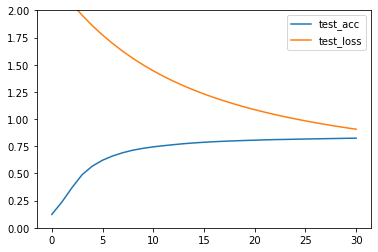

In [12]:
plt.clf()
plt.ylim(0, 2.0)
for i in range(2):
    plt.plot([val[i] for val in hist], label=['test_acc','test_loss'][i])
plt.legend()

In [13]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

In [17]:
net = Net()
net.add(Linear(784, 100))
net.add(Tanh())
net.add(Linear(100,10))
net.add(Softmax())
loss = CrossEntropyLoss()

net.compile(loss=CrossEntropyLoss())

hist = net.fit(train_data, train_labels, lr=0.001, epochs=15, batch_size=256, validation_data=(test_data,test_labels))

Initial train_acc: 0.08406349206349206
Initial train_loss: 2.398345641780953
Initial test_acc: 0.08104761904761905
Initial test_loss: 2.398838686468409
epoch: 1/15
train_acc: 0.15434920634920635
train_loss: 2.251490249749054
test_acc: 0.15304761904761904
test_loss: 2.2517543488189515
epoch: 2/15
train_acc: 0.32126984126984126
train_loss: 2.1349666572695067
test_acc: 0.32
test_loss: 2.1350184023673666
epoch: 3/15
train_acc: 0.4614920634920635
train_loss: 2.0330838895431875
test_acc: 0.4594285714285714
test_loss: 2.032972257465255
epoch: 4/15
train_acc: 0.5491746031746032
train_loss: 1.9401297728608455
test_acc: 0.5500952380952381
test_loss: 1.9399063991002552
epoch: 5/15
train_acc: 0.6039682539682539
train_loss: 1.853882450077456
test_acc: 0.6051428571428571
test_loss: 1.8535947311037433
epoch: 6/15
train_acc: 0.6401587301587301
train_loss: 1.773391430246744
test_acc: 0.6402857142857142
test_loss: 1.7730812520205266
epoch: 7/15
train_acc: 0.6656507936507936
train_loss: 1.698186191503736

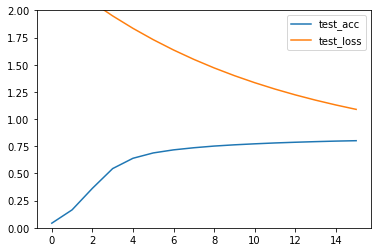

In [16]:
plt.clf()
plt.ylim(0, 2.0)
for i in range(2):
    plt.plot([val[i] for val in hist], label=['test_acc','test_loss'][i])
plt.legend()

In [20]:
net = Net()
net.add(Linear(784, 200))
net.add(Tanh())
net.add(Linear(200,10))
net.add(Softmax())
loss = CrossEntropyLoss()

net.compile(loss=CrossEntropyLoss())

hist = net.fit(train_data, train_labels, lr=0.001, epochs=15, batch_size=256, validation_data=(test_data,test_labels))

Initial train_acc: 0.11517460317460318
Initial train_loss: 2.347975753618626
Initial test_acc: 0.11133333333333334
Initial test_loss: 2.349224316392998
epoch: 1/15
train_acc: 0.22593650793650794
train_loss: 2.2166233458287565
test_acc: 0.22228571428571428
test_loss: 2.218017898902587
epoch: 2/15
train_acc: 0.36273015873015874
train_loss: 2.0990422953031675
test_acc: 0.3616190476190476
test_loss: 2.1005625211323267
epoch: 3/15
train_acc: 0.48428571428571426
train_loss: 1.9912801507007225
test_acc: 0.48114285714285715
test_loss: 1.9929178894280264
epoch: 4/15
train_acc: 0.5714285714285714
train_loss: 1.891607076174321
test_acc: 0.5658095238095238
test_loss: 1.8933582532650277
epoch: 5/15
train_acc: 0.6270793650793651
train_loss: 1.7990942463990132
test_acc: 0.6208571428571429
test_loss: 1.8009565943273573
epoch: 6/15
train_acc: 0.6647301587301587
train_loss: 1.713153886727079
test_acc: 0.6579047619047619
test_loss: 1.7151263528513352
epoch: 7/15
train_acc: 0.6901904761904762
train_loss: 

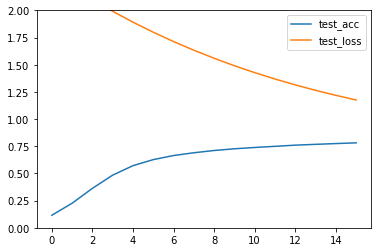

In [21]:
plt.clf()
plt.ylim(0, 2.0)
for i in range(2):
    plt.plot([val[i] for val in hist], label=['test_acc','test_loss'][i])
plt.legend()

In [15]:
net = Net()
net.add(Linear(784, 300))
net.add(Tanh())
net.add(Linear(300,10))
net.add(Softmax())
loss = CrossEntropyLoss()

net.compile(loss=CrossEntropyLoss())

hist = net.fit(train_data, train_labels, lr=0.001, epochs=15, batch_size=256, validation_data=(test_data,test_labels))

Initial train_acc: 0.042444444444444444
Initial train_loss: 2.380343169149706
Initial test_acc: 0.040095238095238094
Initial test_loss: 2.380503252080031
epoch: 1/15
train_acc: 0.16498412698412698
train_loss: 2.2159278561137032
test_acc: 0.16171428571428573
test_loss: 2.2161005740663264
epoch: 2/15
train_acc: 0.36295238095238097
train_loss: 2.0749357352286055
test_acc: 0.36104761904761906
test_loss: 2.075083874477316
epoch: 3/15
train_acc: 0.5447301587301587
train_loss: 1.9489442120696294
test_acc: 0.5417142857142857
test_loss: 1.9490638139497487
epoch: 4/15
train_acc: 0.6394603174603175
train_loss: 1.8346152934228823
test_acc: 0.6350476190476191
test_loss: 1.8347152126343498
epoch: 5/15
train_acc: 0.6886031746031746
train_loss: 1.7304421578049096
test_acc: 0.681047619047619
test_loss: 1.7305364154718352
epoch: 6/15
train_acc: 0.7168571428571429
train_loss: 1.6355270896635559
test_acc: 0.7114285714285714
test_loss: 1.635632400450001
epoch: 7/15
train_acc: 0.7363174603174604
train_loss:

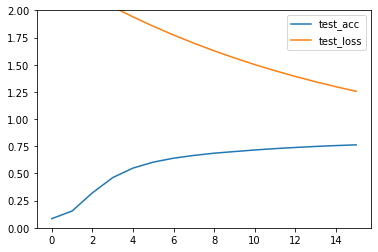

In [18]:
plt.clf()
plt.ylim(0, 2.0)
for i in range(2):
    plt.plot([val[i] for val in hist], label=['test_acc','test_loss'][i])
plt.legend()

In [23]:
net = Net()
net.add(Linear(784, 400))
net.add(Tanh())
net.add(Linear(400,10))
net.add(Softmax())
loss = CrossEntropyLoss()

net.compile(loss=CrossEntropyLoss())

hist = net.fit(train_data, train_labels, lr=0.001, epochs=15, batch_size=256, validation_data=(test_data,test_labels))

Initial train_acc: 0.06841269841269841
Initial train_loss: 2.428863305645242
Initial test_acc: 0.06971428571428571
Initial test_loss: 2.4292837364580784
epoch: 1/15
train_acc: 0.1732063492063492
train_loss: 2.2519095440222463
test_acc: 0.17257142857142857
test_loss: 2.2522876557204645
epoch: 2/15
train_acc: 0.31965079365079363
train_loss: 2.1018354300527435
test_acc: 0.31723809523809526
test_loss: 2.1022442346338805
epoch: 3/15
train_acc: 0.4743174603174603
train_loss: 1.9688625785418008
test_acc: 0.468
test_loss: 1.9693458261013015
epoch: 4/15
train_acc: 0.5774603174603175
train_loss: 1.8492361192580369
test_acc: 0.5733333333333334
test_loss: 1.8498199770387176
epoch: 5/15
train_acc: 0.6401587301587301
train_loss: 1.7410714404539283
test_acc: 0.6315238095238095
test_loss: 1.7417741695976119
epoch: 6/15
train_acc: 0.6788888888888889
train_loss: 1.6431428793997092
test_acc: 0.6722857142857143
test_loss: 1.6439798248928594
epoch: 7/15
train_acc: 0.7058730158730159
train_loss: 1.554477626

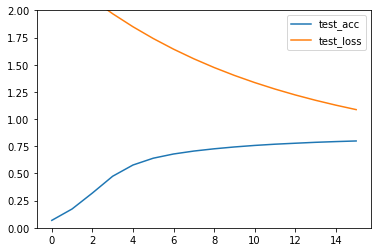

In [24]:
plt.clf()
plt.ylim(0, 2.0)
for i in range(2):
    plt.plot([val[i] for val in hist], label=['test_acc','test_loss'][i])
plt.legend()